<a href="https://colab.research.google.com/github/mantoan-thi/Machine-Learning-Projects-with-Python/blob/main/Previs%C3%A3o_de_defeitos_QA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando bibliotecas essenciais

In [ ]:
!pip install autots

In [ ]:
#!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [6]:
!pip uninstall openpyxl
!pip install openpyxl 

Found existing installation: openpyxl 2.5.9
Uninstalling openpyxl-2.5.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/openpyxl-2.5.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/openpyxl/*
Proceed (y/n)? y
  Successfully uninstalled openpyxl-2.5.9
     |████████████████████████████████| 242 kB 4.2 MB/s 


In [ ]:
!pip install s3fs --upgrade

In [25]:
# Modelagem
import pandas as pd
from pandas_datareader import data as web
import plotly.graph_objects as go
from datetime import date, datetime
import numpy as np
from matplotlib import pyplot
import plotly.express as px

# Redes neurais
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
from keras.models import load_model

# Facebook
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import plot_cross_validation_metric

# ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

# Dados da Bolsa

In [800]:
# criar um DataFrame vazio
df = pd.DataFrame()

# escolher a ação desejada
acao = 'ITUB3.SA'
 
# importar dados para o DataFrame
df = web.DataReader(acao, data_source='yahoo', start='01-01-2019')

trace1 = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': acao,
    'showlegend': False
}
 
data = [trace1]
layout = go.Layout()
 
fig = go.Figure(data=data, layout=layout)
fig.show()

In [828]:
def retorna_ativos(acao):
  # escolher a ação desejada
  #acao = 'ITUB3.SA'

  # importar dados para o DataFrame
  df = web.DataReader(acao, data_source='yahoo', start='01-01-2019')['Adj Close']
  df = pd.DataFrame(df).reset_index()
  df.rename(columns={'Date': 'ds','Adj Close':'y'},inplace=True)
  data = df[['ds','y']]
  data.reset_index(drop=True, inplace=True)
  return data

#Modelagem de dados

In [2]:
# Carrega a planilha
df = pd.read_excel('/content/Indicadores Internos SAP rev 17A.xlsx',sheet_name='Base de dados')

# Renomear as colunas
df.columns = df.iloc[1]

# Excluir as linhas 0 e 1
for i in range(0,2):
  df.drop(i,inplace=True)

# Retira o index
df.reset_index(drop=True, inplace=True)

# Exclui as linhas que contém: fechamento e 200%
df = df[(df['Processo']!='fechamento') & (df['Processo']!='200%')]

# Retirando as colunas abaixo
df = df[['Data','Turno','Projeto','QTD DEF']]

# Excluir os valores nan
df.dropna(inplace=True)

# Converte as datas
df['Data'] = df['Data'].apply(lambda x: x.strftime('%d/%m/%Y'))

In [3]:
lista_de = ['T9','T9LT novo','TRYX NOVO','360b','833B','TRYX novo','T5NR novo','T9LM NOVO','T5R NOVO','T5RN NOVO','T5NM NOVO','T5NM']
lista_para = ['T9LT','T9LT','TRYX','360B','833W','TRYX','T5NR','T9LT','T5NR','T5NR','T5NR','T5NR']

# Ajustando...
de = 'T9'
para = 'T9LT'
for i in range(0,len(lista_de)):
  df['Projeto'] = df['Projeto'].apply(lambda x: lista_para[i] if x == lista_de[i] else x)

# Extraindo os projetos
lista_proj = list(set(df['Projeto']))

print('Quantidade de projetos: ',len(lista_proj))
lista_proj

Quantidade de projetos:  15


['TRYX',
 '833W',
 'Actros',
 'T5/TR',
 'Mahle',
 'Kongsberg',
 'VIVA PUP',
 'kanjiko',
 '474B',
 '740B',
 'T9LM',
 '360B',
 'T5NR',
 'T9LT',
 'T00A']

In [4]:
# Gráfico...
n_df = df[df['Projeto']=='360B']
fig = px.line(n_df, x='Data', y='QTD DEF', title='Projetos',color='Projeto')
fig.show()

Plotar gráficos

In [5]:
turnos = ['A','B']
resumo = []

for t in turnos:
  for proj in lista_proj:
    new_df = df[(df['Turno']==t) & (df['Projeto']==proj)]
    resumo.append([proj,t,new_df.shape[0]])

resumo = pd.DataFrame(resumo,columns=['Projeto','Turno','Qtde def'])
resumo.sort_values(by=['Qtde def'], ascending=False,inplace=True)

# Top 10...
resumo.head(10)

,Projeto,Turno,Qtde def
11,360B,A,10491
9,740B,A,9303
26,360B,B,7403
24,740B,B,6566
8,474B,A,2729
3,T5/TR,A,2267
14,T00A,A,2141
13,T9LT,A,1640
0,TRYX,A,1320
23,474B,B,1144


Funções

In [6]:
def previsao(df,p,proj):
  #df['cap'] = 8.5
  #m = Prophet(growth='logistic')
  m = Prophet(daily_seasonality = True)
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  #future['cap'] = 8.5
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  print('Projeto: ',proj)
  y_pred = forecast['yhat'][-(p):].values
  print('média de defeitos previsto para os próximos 30 dias: ',y_pred.mean())
  fig1 = m.plot(forecast,figsize=(12,8))
  a = add_changepoints_to_plot(fig1.gca(), m, forecast)

In [7]:
def previsao_comp(df,p,proj):
  m = Prophet()
  m = Prophet(changepoint_prior_scale=0.001)
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  print('Projeto: ',proj)
  fig2 = m.plot_components(forecast)

In [8]:
def previsao_comp_x(df,p,proj):
  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  forecast = m.predict(future)
  y_true = df['y'][-(p):].values
  y_pred = forecast['yhat'][-(p):].values
  mae = mean_absolute_error(y_true, y_pred)
  print('Projeto: ',proj)
  print('MAE: %.3f' % mae)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  pyplot.figure(figsize=(15,8))
  pyplot.plot(y_true, label='Actual')
  pyplot.plot(y_pred, label='Predicted')
  pyplot.legend()
  pyplot.show()

In [9]:
pd.DataFrame(lista_proj)

,0
0,TRYX
1,833W
2,Actros
3,T5/TR
4,Mahle
5,Kongsberg
6,VIVA PUP
7,kanjiko
8,474B
9,740B


In [10]:
t='A'
p = '360B'
tempo = 60
new_df = df[df['Projeto']== p]

novo = pd.DataFrame()
novo['ds'] = new_df['Data']
novo['y'] = new_df['QTD DEF']

novo.dropna(inplace=True)

print('Projeto: ',p)

Projeto:  360B


In [12]:
df.columns

Index(['Data', 'Turno', 'Projeto', 'QTD DEF'], dtype='object', name=1)

In [13]:
def carregar(prjt, trn):
  # Carrega a planilha
  df = pd.read_excel('/content/Indicadores Internos SAP rev 17A.xlsx',sheet_name='Base de dados')

  # Renomear as colunas
  df.columns = df.iloc[1]

  # Excluir as linhas 0 e 1
  for i in range(0,2):
    df.drop(i,inplace=True)

  # Retira o index
  df.reset_index(drop=True, inplace=True)

  # Exclui as linhas que contém: fechamento e 200%
  df = df[(df['Processo']!='fechamento') & (df['Processo']!='200%')]

  # Retirando as colunas abaixo
  df = df[['Data','Turno','Projeto','QTD DEF']]

  # Excluir os valores nan
  df.dropna(inplace=True)

  # Converte as datas
  df['Data'] = df['Data'].apply(lambda x: x.strftime('%d/%m/%Y'))

  lista_de = ['T9','T9LT novo','TRYX NOVO','360b','833B','TRYX novo','T5NR novo','T9LM NOVO','T5R NOVO','T5RN NOVO','T5NM NOVO','T5NM']
  lista_para = ['T9LT','T9LT','TRYX','360B','833W','TRYX','T5NR','T9LT','T5NR','T5NR','T5NR','T5NR']

  # Ajustando...
  de = 'T9'
  para = 'T9LT'
  for i in range(0,len(lista_de)):
    df['Projeto'] = df['Projeto'].apply(lambda x: lista_para[i] if x == lista_de[i] else x)

  # Sem filtro de Turno
  new = pd.DataFrame()
  new = df[(df['Turno']==trn) & (df['Projeto']==prjt)]
  new = new.groupby(by=['Data'])['QTD DEF'].sum()
  new.drop(columns=['Turno','Projeto'],axis=1,inplace=True)
  new.dropna(inplace=True)
  new = pd.DataFrame(new)
  new.reset_index(inplace=True)
  new.rename(columns={'Data': 'ds','QTD DEF': 'y'}, inplace = True)

  # Sem filtro de Turno
  #new_df = df[df['Projeto']== p]
  #new = pd.DataFrame()
  #new['ds'] = new_df['Data']
  #new['y'] = new_df['QTD DEF']
  def num(x):
    numer = str(x)
    if numer.isnumeric() == False:
      return True
    else:
      return False
  ind_drop = new[new['y'].apply(lambda x: num(x))].index
  new_1 = new.drop(ind_drop)
  new_1 = new_1.groupby(by=['ds'])['y'].sum()
  new_1 = pd.DataFrame(new_1)
  new_1.reset_index(inplace=True)
  print('Projeto: ',prjt)

  
  return new_1

# Definição do Projeto

In [259]:
t ='A'
p = '360B'
tempo = 30

resumo.head(4)

,Projeto,Turno,Qtde def
11,360B,A,10491
9,740B,A,9303
26,360B,B,7403
24,740B,B,6566


#Previsão de defeitos com Prophet do Facebook

In [260]:
# Prever defeitos
new_df = carregar(p,t)

# Prever preços
#new_df = retorna_ativos('ITUB3.SA')

Projeto:  360B


In [261]:
# The Prophet class (model)
fbp = Prophet(seasonality_mode='multiplicative') 
fbp.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
#fbp.add_regressor('regressor', mode='additive')
#fbp = Prophet() 
 # Fit the model 
fbp.fit(new_df)
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=tempo) 
forecast = fbp.predict(fut)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [262]:
# Plot dados
lista_prev = []
y_pred = forecast['yhat'][-tempo:].values
print('Média de defeitos previsto para os próximos '+str(tempo)+' dias: ',round(y_pred.mean(),2))
previsao_def = pd.DataFrame(forecast[['ds','yhat']][-tempo:].values,columns=['Data','Qtde defeitos'])
print('\n')
pd.DataFrame(previsao_def)

Média de defeitos previsto para os próximos 30 dias:  40.08




,Data,Qtde defeitos
0,2021-12-12,30.214995
1,2021-12-13,37.053676
2,2021-12-14,37.981989
3,2021-12-15,33.42221
4,2021-12-16,33.395514
5,2021-12-17,37.911076
6,2021-12-18,37.593583
7,2021-12-19,33.91831
8,2021-12-20,43.846766
9,2021-12-21,47.161573


In [263]:
previsao_profeta = previsao_def
fig = px.line(previsao_def, x='Data', y='Qtde defeitos', title='Projeto: '+p)
fig.show()

In [264]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(fbp, forecast)

Detecção automática de ponto de mudança no Profeta

Por padrão, o Profeta especifica 25 pontos de mudança potenciais que são colocados uniformemente nos primeiros 80% da série temporal. As linhas verticais nesta figura indicam onde os pontos de mudança potenciais foram colocados

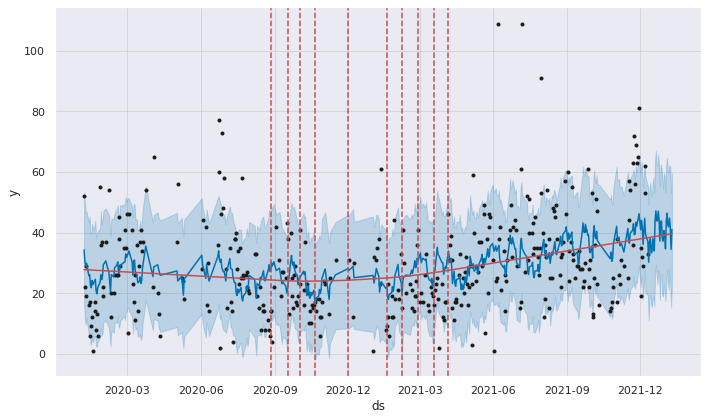

In [265]:
from fbprophet.plot import add_changepoints_to_plot
fig = fbp.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), fbp, forecast,cp_linestyle='--')

#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

Tendência, componentes semanais, sazonais, anuais e diários

Projeto:  360B


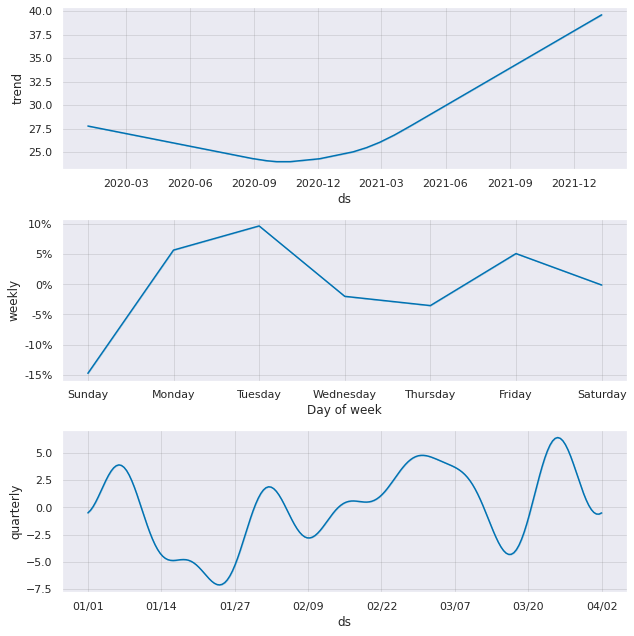

In [266]:
print('Projeto: ',p)
fbp.plot_components(forecast)
plt.show()

# Previsão de defeitos com rede LSTM

In [267]:
# Prever defeitos
df = carregar(p,t)

# Prever preços
#df = retorna_ativos('ITUB3.SA')

Projeto:  360B


O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em n dias (forward_days), tendo como base os m dias anteriores (look_back).

In [268]:
look_back = 40
forward_days = 10
num_periods = 30

Data visualization ( Vizualizando os dados )

In [269]:
fig = px.line(df, x='ds', y='y', title='Projeto:'+p)
fig.show()

Data normalization ( Normalizando os dados )

In [270]:
array = df['y'].values.reshape(df.shape[0],1)
array[:5]

array([[1],
       [32],
       [31],
       [52],
       [35]], dtype=object)

In [271]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.        ],
       [0.28703704],
       [0.27777778],
       [0.47222222],
       [0.31481481]])

Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste - 
Vamos separar para os últimos k períodos (num_periods) para testar o modelo. A cada período, o modelo irá prever os próximos n dias. O resto será utilizado para o treinamento (Treino e Validação).

In [272]:
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [273]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [274]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

Treinando a LSTM

In [275]:
#Optionaly, you can load a model
#model = load_model('model.h5')

In [276]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 100

#Constríndo o model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=1)

Epoch 1/100
13/13 [==============================] - 5s 103ms/step - loss: 0.0906 - val_loss: 0.0396
Epoch 2/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0533 - val_loss: 0.0298
Epoch 3/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0425 - val_loss: 0.0280
Epoch 4/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0396 - val_loss: 0.0248
Epoch 5/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0392 - val_loss: 0.0263
Epoch 6/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0384 - val_loss: 0.0248
Epoch 7/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0383 - val_loss: 0.0254
Epoch 8/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0385 - val_loss: 0.0252
Epoch 9/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0388 - val_loss: 0.0257
Epoch 10/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0385 - val_loss: 0.025

In [277]:
# Parâmetros...
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30)                9720      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 20,430
Trainable params: 20,430
Non-trainable params: 0
_________________________________________________________________


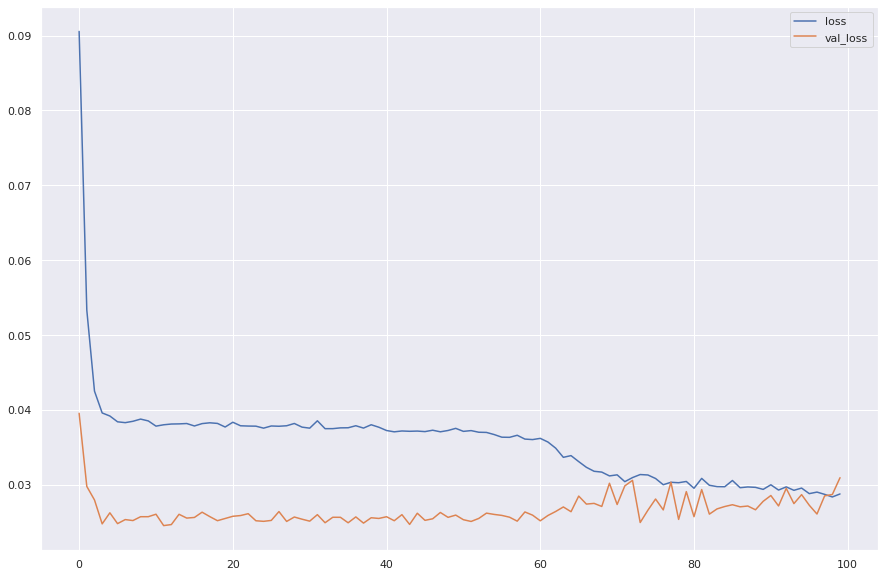

In [278]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [279]:
#Salavando o model
file_name = 'Redes_defects_LSTM_{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `Redes_defects_LSTM_40_FD10_E100_F50_S30.h5` to disk


Vamos prever os dados de Teste para o resultado

In [280]:
Xt = model.predict(X_test)

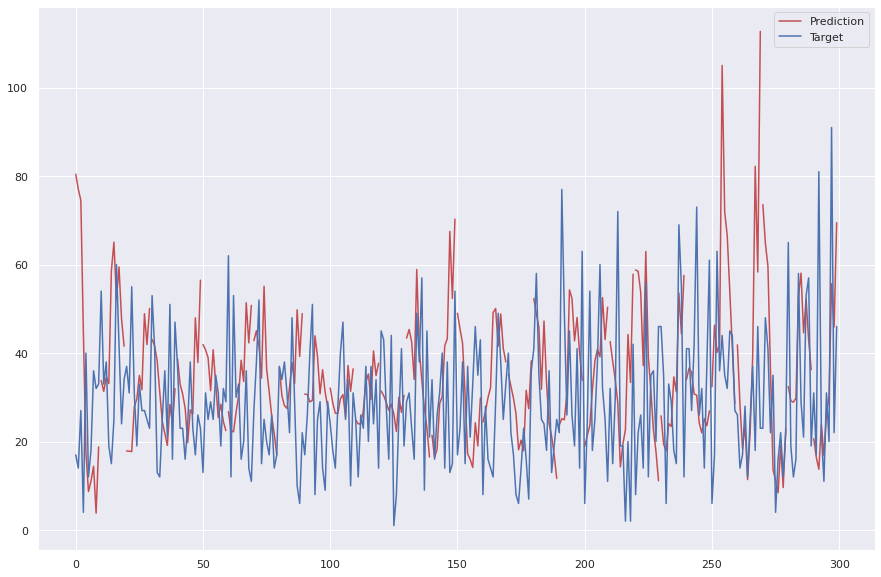

In [281]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste

In [282]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [283]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [284]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [285]:
y = np.concatenate((ytrain, ytest), axis=0)

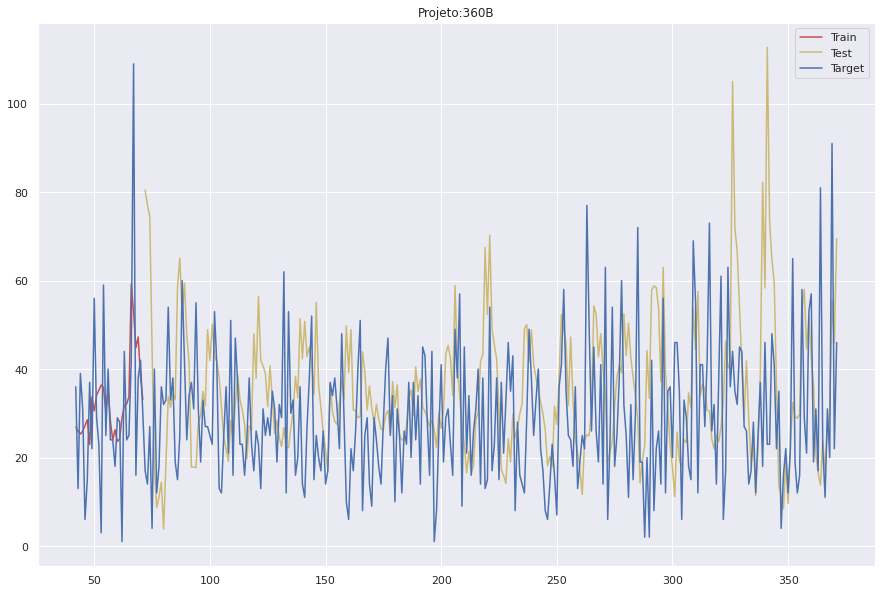

In [286]:
plt.figure(figsize = (15,10))

plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')

plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')
plt.title('Projeto:'+p)
plt.legend(loc='best')
plt.show()

# Previsão de defeitos com ARIMA

In [293]:
# Carregando dados
# Prever defeitos
df = carregar(p,t)

# Prever preços
#df = retorna_ativos('ITUB3.SA')

df.sort_values(by=['ds'],inplace=True)
df.set_index('ds', inplace=True)
#df.drop(columns=['index'],inplace=True)

Projeto:  360B


Criando base de treino e teste

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


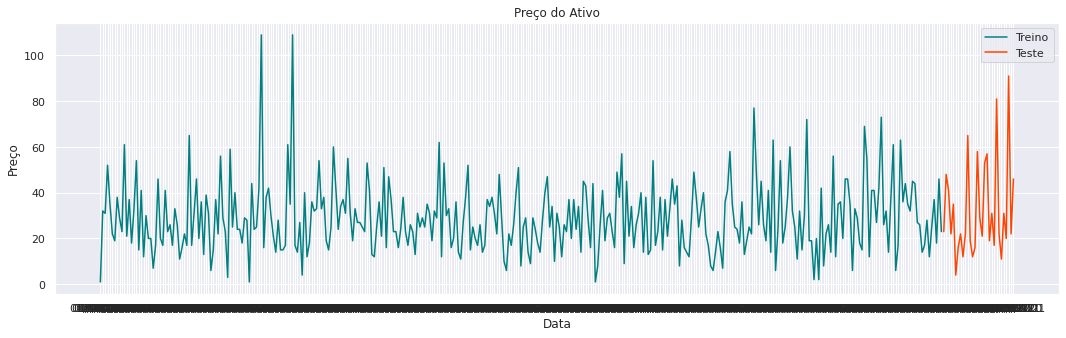

In [294]:
dias = 30
treino = df.iloc[:-dias,0:1].copy()
teste = df.iloc[-dias:,0:1].copy()
plt.figure(figsize=(18,5))
plt.title('Preço do Ativo')
plt.plot(treino['y'], color='teal')
plt.plot(teste['y'], color='orangered')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

Teste de estacionariedade e verificando Correlações

Para se criar uma previsão de série temporal é necessário que ela seja estacionária, ou seja, que ela tenha as seguintes condições relativamente constantes: média, variância e autocorrelação.

Abaixo irei usar a função abaixo para plotar a série, sua distribuição, autocorrelação e autocorrelação parcial além de checar a estacionariedade usando o teste de Dickey Fuller:

In [295]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Série de Preços')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição dos Valores')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Para verificar se a série de treino é estacionária, iremos usar o valor P de 5% como base para estacionariedade, caso o valor P do teste seja inferior a 5% podemos considerar que a série é estacionária:

Resultados do teste de Dickey-Fuller:
Teste Statistico           -3.7399
Valor-P                     0.0036
Lags Usados                13.0000
Números de Observações    337.0000
Valores Críticos (1%)      -3.4499
Valores Críticos (5%)      -2.8702
Valores Críticos (10%)     -2.5714
dtype: float64


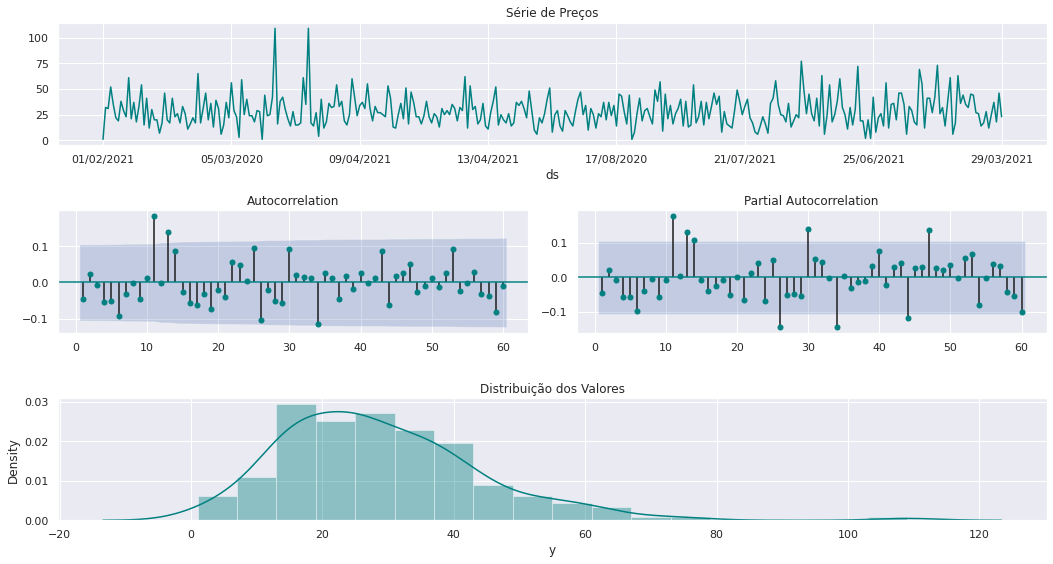

In [296]:
# Aqui os dados de qualidade estão no formato int, sendo necessário transforma para float
treino['y'] = treino['y'].apply(lambda x: float(x))


checar_estacionariedade(treino['y'], lags_plots=60)

Analisando o gráfico da série de preços, nota-se que ele tem uma leve tendência de alta, observando os dados estatísticos a série ficou com o valor P de 21,5%, a distribuição dos dados não segue uma normalidade gaussiana, e as características da autocorrelação mostram correlações significativas em todos os lags, isso é sinal de uma série com tendência e que pode-se fazer ao menos uma diferenciação.

Assim, essa série não satisfaz os critérios estabelecidos para ser considerada estacionária.

Vou fazer a primeira diferenciação para retirar a tendência e ficar somente as movimentações dia-a-dia:

Resultados do teste de Dickey-Fuller:
Teste Statistico          -11.3376
Valor-P                     0.0000
Lags Usados                12.0000
Números de Observações    337.0000
Valores Críticos (1%)      -3.4499
Valores Críticos (5%)      -2.8702
Valores Críticos (10%)     -2.5714
dtype: float64


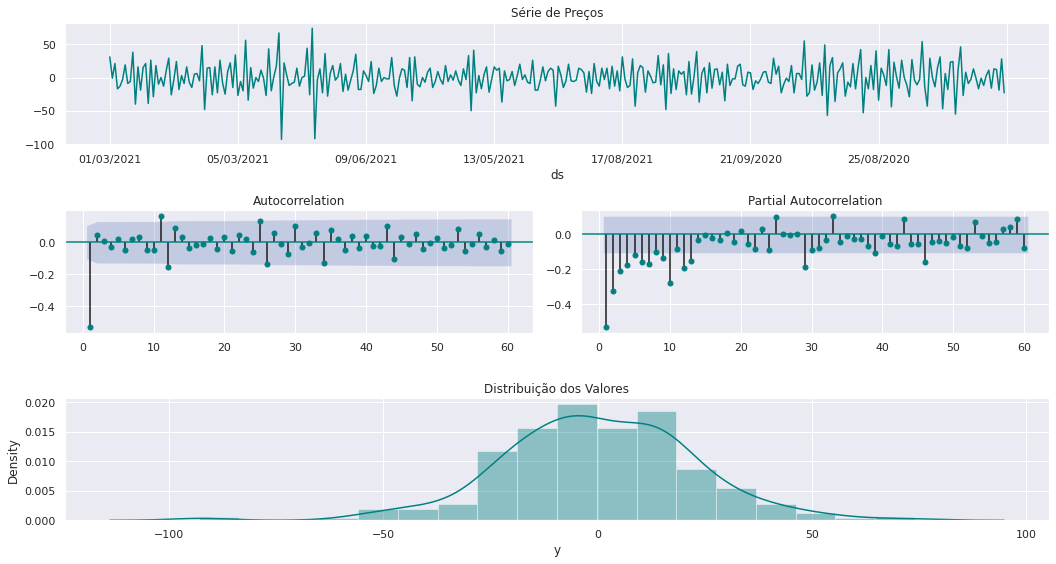

In [297]:
checar_estacionariedade(treino['y'].diff().dropna(), lags_plots=60)

O teste de Dickey Fuller retornou o valor P de zero, isso significa que a série tornou-se estacionária, para complementar, nota-se no gráfico que a tendência desapareceu e os preços estão relativamente estáveis.

No gráfico de auto correlação os valores vão decrescendo gradualmente, diferente do gráfico sem diferenciação.

A auto correlação parcial cai mais abruptamente, demonstrando que os valores que realmente impactam sobre os valores atuais são principalmente os 3 primeiros lags, aparentemente não há correlação sazonal significativa para ser considerada nas previsões.

Dessa maneira, podemos considerar os 3 primeiros lags para um modelo ARIMA com uma diferenciação, assim sendo usaremos a seguinte terminologia para o modelo: ARIMA(3,1,0)

Criando o Modelo

Inicialmente o modelo será criado com base nos dados de treino, assim, os coeficientes para os 3 lags auto correlacionados serão gerados e servirão para testar a extrapolação de 5 dias consecutivos na base de testes.

Existem diversas maneiras de se fazer extrapolações para o futuro, as principais são:

Criar um modelo para cada dia a ser previsto e agregar tudo posteriormente,
Recursivo, prevendo o primeiro dia e usar essa previsão como base para prever o próximo dia.
Usaremos o último modelo neste exemplo, neste caso iremos prever os próximos 5 dias, comparar com dados reais, adicionar estes últimos novamente na base para fazer uma nova extrapolação, posteriormente iremos calcular o erro do modelo e analisar fatos relevantes da previsão.

In [298]:
# Treinando o modelo
modelo = ARIMA(treino, order=(3,1,0)).fit()
pred_treino = modelo.predict()

Vamos agora comparar os dados reais com os previstos, como a previsão foi feita sobre o modelo com diferenciação (como pode ser visto abaixo) o primeiro valor real será adicionado e somado cumulativamente para ter de volta a base de preço em R$/m3.

In [299]:
# Base de previsão com diferenciação
pred_treino[:5]

ds
01/03/2021     0.027440
01/06/2021   -16.507944
01/07/2020    -9.418449
01/07/2021   -22.298221
01/08/2020     3.483452
dtype: float64

In [300]:
# Voltando para a base de preços em R$/m3
pred_treino[0] += treino.iloc[0,0]
pred_treino = np.cumsum(pred_treino)
pred_treino.head()

ds
01/03/2021     1.027440
01/06/2021   -15.480504
01/07/2020   -24.898953
01/07/2021   -47.197174
01/08/2020   -43.713722
dtype: float64

In [301]:
treino['Pred Y'] = pred_treino
treino.dropna(inplace=True)
treino.head()

,y,Pred Y
ds,,
01/03/2021,32.0,1.027440
01/06/2021,31.0,-15.480504
01/07/2020,52.0,-24.898953
01/07/2021,35.0,-47.197174
01/08/2020,22.0,-43.713722


Agora os valores previstos serão adicionados na variável de treino para plotarmos o gráfico com as duas séries:

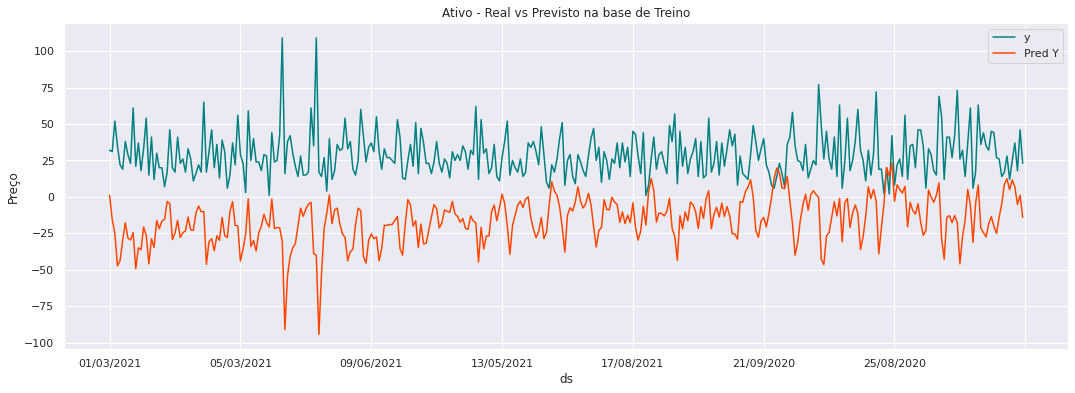

In [302]:
# Plotando o gráfico
treino.plot(figsize=(18,6), 
            title='Ativo - Real vs Previsto na base de Treino',
           color=['Teal','orangered'])
plt.ylabel('Preço')
plt.show()

Na base de treino o modelo consegue capturar os principais momentos do mercado. Somente quando há maiores variações que a previsão não consegue capturar o movimento, agora vamos analisar o erro do modelo:

In [303]:
#Medindo o erro do treino pela métrica Root Mean Squared Error
from sklearn.metrics import mean_squared_error
erro = sqrt(mean_squared_error(treino['y'], treino['Pred Y']))
print(f'O RMSE foi de {round(erro,4)}/sc')

O RMSE foi de 49.745/sc


Obtendo os Coeficientes

Após treinar o modelo, podemos obter os coeficientes de multiplicação dos lags junto com o valor da constante, esses valores servirão como base para extrapolarmos as previsões para os próximos 5 dias.

In [304]:
# Pegando os coeficientes de múltiplicação dos lags para usar na base de testes:
const, l1, l2, l3 = modelo.params

print(f'Valor da constante {round(const,4)}')
print(f'Coeficientes do Lag 1: {round(l1,4)}, Lag 2: {round(l2,4)} e Lag 3: {round(l3,4)}')

Valor da constante 0.0274
Coeficientes do Lag 1: -0.7782, Lag 2: -0.4773 e Lag 3: -0.2097


O próximo passo é criar uma função para fazer as previsões, usarei todas as bases com diferenciação, criarei a previsão para 5 períodos adiante e atualizarei os dados reais com mais 5 dias e assim sucessivamente até finalizarem os dados de teste.

In [305]:
def prever_n_per(treino, teste, passos):
    
    # Adicionando a série com diferenciação para projetar previsões
    diff_treino = treino.diff().dropna().values
    hist = [x for x in diff_treino]

    diff_teste = teste.diff().dropna().values
    diff_teste = [x for x in diff_teste]

    # Adicionando primeira diferenciação no teste que ficou entre o treino e teste
    prim_diff = teste[0] - treino[-1]
    diff_teste.insert(0, prim_diff)
    
    prev = []

    for i in range(0,len(teste),passos):
        for j in range(passos):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            prev.append(yhat)
            # usando a previsão atual como base para novas previsões
            hist.append(yhat)
        obs = diff_teste[i:i+passos]
        hist = list(np.append(hist,obs))
    return prev

In [306]:
# Testando a função
steps = 5
prev = prever_n_per(treino['y'], teste['y'], passos=steps)
print('Previsões antes de reverter os preços: ')
print(prev[:5])

Previsões antes de reverter os preços: 
[8.546645718852352, -1.518840614129851, 1.9543618002168688, -2.5610397470017086, 1.406135486328401]


Do mesmo jeito que criamos a função para prever os preços com 5 dias de extrapolação, iremos criar a função abaixo para transformar os preços previstos para a base comparável com os preços reais da base de teste.

In [307]:
def inverter_diff(treino, teste, previsão, passos):
    '''
    Usando o último dia da base de treino, após isso, usa o último valor previsto como base sucessivamente.
    
    A cada passo, volta a usar o primeiro valor da base de teste que se tornou real.
    '''
    treino = [x for x in treino]
    teste = [x for x in teste]
    prev_inv = []
    
    for i in range(0,len(teste), passos): 
        inverter = previsão[i] + treino[-1]
        prev_inv.append(inverter)
        
        for j in range(passos-1):
            inverter += previsão[i+j+1]
            prev_inv.append(inverter)
        treino = np.append(treino, teste[i:i+passos])
    return prev_inv

In [308]:
# Adicionando a previsão na base de testes para comparar posteriormente
teste['Previsão 5D'] = inverter_diff(treino['y'],
                                    teste['y'],
                                    prev, passos=steps)

Plotando o Comparativo

Para finalizar, a função abaixo irá separar cada previsão pelos períodos de 5 dias e comparar com a base de testes:

In [309]:
def plotar_comparativo(orig, prev, passos, titulo='', figsize=(18,8)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    prev = np.array(prev)
    plt.plot(orig, label='Real', color='teal')
    
    for i in range(0,len(orig), passos):
        eixo_x = [x for x in range(i,i+passos)]
        plt.plot(eixo_x, prev[i:i+passos], color='orangered')
    
    plt.title(titulo)
    plt.ylabel('Preços')
    plt.show()

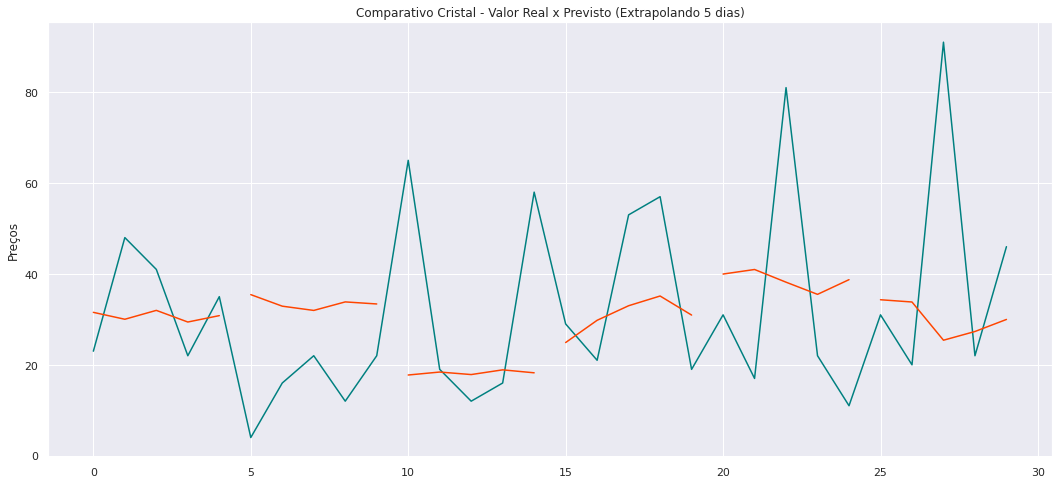

In [312]:
plotar_comparativo(teste['y'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo - Valor Real x Previsto')

In [315]:
erro_teste = sqrt(mean_squared_error(teste['y'], teste['Previsão 5D']))
print(f'O RMSE da base de testes foi de {round(erro_teste,4)}/sc')

O RMSE da base de testes foi de 22.8984/sc


Avaliando o gráfico acima, nota-se que a principal característica desse tipo de previsão é que ele segue a tendência mais recente que está sendo negociada, porém ainda há espaço para melhoras, o modelo não é capaz de prever possíveis mudanças de tendências.

No próximo vai ser analisar o erro (previsto - real), pois neste tipo de análise pode-se obter informações para melhorar o modelo.

Analisando o Erro

Para analisar o erro criarei uma função semelhante às anteriores, irão ser analisados os valores médios de cada um dos 5 passos, normalmente a tendência é que o erro, neste caso o RMSE, aumente de acordo com os períodos que vão se expandindo devido às incertezas, veremos abaixo:

In [314]:
def erro_n_passos(orig, prev, passos, plot=True):
    # Calculando o RMSE de cada linha
    erro = ((np.array(orig) - np.array(prev))**2)**(1/2)
    
    # Mudando o formato para ficar: (erros/exemplos, passos)
    erro = erro.reshape(int(len(erro)/passos), passos)
    
    # Fazendo a média do erro para cada passo
    media = erro.mean(axis=0)
    
    # Plotando o gráfico de erro
    if plot:
        indice = np.arange(0,passos)
        plt.figure(figsize=(12,4))
        plt.plot(media, 'o-', color='teal', markersize=8)
        plt.title('Erro Médio para Cada Passo', fontsize=15)
        plt.xlabel('Passos', fontsize=15)
        plt.ylabel('Erro', fontsize=15)
        for x,y in zip(indice, media):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
        plt.yticks([x for x in np.linspace(min(media)-0.2, max(media)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'O RMSE para cada passo ficou assim: \n{media}')

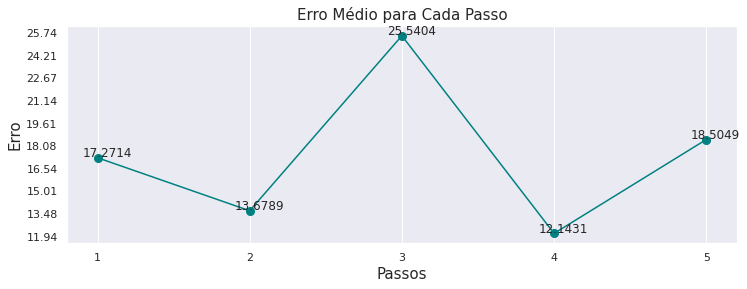

O RMSE para cada passo ficou assim: 
[17.271436802586276 13.678872961163458 25.540357167757424
 12.14314154103829 18.504891396349365]


In [316]:
erro_passo = erro_n_passos(teste['y'], teste['Previsão 5D'], steps)
erro_passo

Como previsto, a cada passo, a tendência é que o erro aumente, isso é devido ao aumento das incertezas quanto ao futuro e também que as previsões a partir do segundo passo são feitas sobre valores previstos e não reais.

Abaixo algumas ideias podem ajudar a melhorar a acurácia do modelo:

Pode-se criar um ensemble de vários modelos (LSTM, Garch, MLP, TBATS, etc) e fazer uma média dos preços,
Alguns modelos podem ter previsões melhores para algum período específico, pode-se usar a cada período o modelo que tiver o menor erro, podendo assim, ter um modelo final com bases de modelos diferentes e com erros menores,
Analisar métricas de erro diferentes tipo MAE, Bias, etc para verificar características Específicas de cada tipo de métrica,
Testar possíveis lags sazonais para prever movimentos recorrentes,
Adicionar dados externos correlacionados,
Normalizar os dados,
Fazer a transformação com logaritmos ou usando a transformação Box-Cox.
Modelos simples ou até com técnicas de Inteligência Artificial para criar previsões com vários períodos adiante são sem dúvidas uma ferramenta de extrema importância.

Diante de um mercado cada vez mais competitivo, criar um modelo com acurácia testada pode ser um diferencial para a empresa, pois ela poderá captar possíveis movimentos de mercado que podem ser essenciais na tomada de decisão do administrador.

Modelos semelhantes a este podem ser usados como ferramentas auxiliares para se criar fluxos de caixa, administrar produção e estoques, como também identificar oportunidades de mercado.

Espero que tenha gostado, qualquer dúvida ou informação, estou à disposição para responder eventuais questionamentos, segue também o link do meu LinkedIn para contato.

Adicional:

Abaixo criei uma animação, mostrando a dinâmica das previsões com as atualizações dos preços reais posteriormente:

In [ ]:
%matplotlib inline

passos = 5
eixo_x_prev = []
eixo_x_real = [x for x in range(len(teste))]
prev = []
pred = np.array([x for x in teste['Previsão 5D']])
base = [x for x in teste['y']]

for i in range(0,len(teste), passos):
    eixo_x_prev.append([x for x in range(i,i+passos)])
    prev.append([x for x in pred[i:i+passos]])

# Criando a base dos gráficos
fig = plt.figure(figsize=(10.5,5))
plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

def animate(i):
    plt.plot(eixo_x_prev[i], prev[i], c='orangered', lw=1)
    plt.plot(eixo_x_real[:i*passos], base[:i*passos], c='teal', lw=0.50)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Preços', fontsize=15)
plt.title('Comparativo Preço do ativo - Real x Previsto', fontsize=15)
plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])
    

ani = FuncAnimation(fig, animate, frames=50, interval=250)
#ni.save('/tmp/movie.mp4', writer='ffmpeg', extra_args=['-loglevel', 'verbose']) 
plt.show()


#Previsão de defeitos AutoTS

In [317]:
# Carregando dados
df = carregar(p,t)

Projeto:  360B


In [318]:
from autots import AutoTS
model = AutoTS(forecast_length=tempo, frequency='infer', ensemble='simple',drop_data_older_than_periods=200)
model = model.fit(df, date_col='ds', value_col='y', id_col=None)
prediction = model.predict()
forecast = prediction.forecast
print(forecast)

Inferred frequency is: None
Frequency is 'None'! Input frequency not recognized.
Old data dropped by `drop_data_older_than_periods`.
Model Number: 1 with model AverageValueNaive in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model DatepartRegression in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10
Epoch 1/50
6/6 [==============================] - 5s 6ms/step - loss: 0.3790
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3731
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3683
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3696
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3690
Epoch 6/5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 45 with model GLM in generation 0 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 45: GLM
Model Number: 46 with model ETS in generation 0 of 10
Template Eval Error: ImportError("cannot import name 'STL' from 'statsmodels.tsa.seasonal' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/seasonal.py)") in model 46: ETS
Model Number: 47 with model FBProphet in generation 0 of 10
Model Number: 48 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 48: GluonTS
Model Number: 49 with model UnobservedComponents in generation 0 of 10
Model Number: 50 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 50: VAR
Model Number: 51 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 51: VECM
Model N

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 73 with model ARDL in generation 0 of 10
Template Eval Error: ImportError("cannot import name 'ARDL' from 'statsmodels.tsa.api' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/api.py)") in model 73: ARDL
Model Number: 74 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 74: GluonTS
Model Number: 75 with model FBProphet in generation 0 of 10
Model Number: 76 with model ZeroesNaive in generation 0 of 10
Model Number: 77 with model MultivariateMotif in generation 0 of 10
Template Eval Error: AttributeError("module 'numpy.lib.stride_tricks' has no attribute 'sliding_window_view'") in model 77: MultivariateMotif
Model Number: 78 with model MultivariateMotif in generation 0 of 10
Template Eval Error: AttributeError("module 'numpy.lib.stride_tricks' has no attribute 'sliding_window_view'") in model 78: MultivariateMotif
Model Number: 79 with model Sectiona

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 123 with model MultivariateMotif in generation 0 of 10
Template Eval Error: AttributeError("module 'numpy.lib.stride_tricks' has no attribute 'sliding_window_view'") in model 123: MultivariateMotif
Model Number: 124 with model GLS in generation 0 of 10
Model Number: 125 with model ARDL in generation 0 of 10
Template Eval Error: ImportError("cannot import name 'STL' from 'statsmodels.tsa.seasonal' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/seasonal.py)") in model 125: ARDL
Model Number: 126 with model MultivariateMotif in generation 0 of 10
Template Eval Error: AttributeError("module 'numpy.lib.stride_tricks' has no attribute 'sliding_window_view'") in model 126: MultivariateMotif
Model Number: 127 with model Theta in generation 0 of 10
Template Eval Error: ModuleNotFoundError("No module named 'statsmodels.tsa.forecasting'") in model 127: Theta
Model Number: 128 with model GLS in generation 0 of 10
Model Number: 129 with model DatepartRegression in generation 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 175 with model FBProphet in generation 1 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 176 with model FBProphet in generation 1 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 177 with model FBProphet in generation 1 of 10
Model Number: 178 with model SectionalMotif in generation 1 of 10
Model Number: 179 with model SectionalMotif in generation 1 of 10
Model Number: 180 with model SectionalMotif in generation 1 of 10
Model Number: 181 with model SectionalMotif in generation 1 of 10
Model Number: 182 with model WindowRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 182: WindowRegression
Model Number: 183 with model WindowRegression in generation 1 of 10
Model Number: 184 with model WindowRegression in generation 1 of 10
Model Number: 185 with model GluonTS in generation 1 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 185: GluonTS
Model Number: 186 with model GluonTS in generation 1 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incom

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 254 with model FBProphet in generation 2 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 255 with model FBProphet in generation 2 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 256 with model FBProphet in generation 2 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 257 with model FBProphet in generation 2 of 10
Model Number: 258 with model GluonTS in generation 2 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 258: GluonTS
Model Number: 259 with model GluonTS in generation 2 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 259: GluonTS
Model Number: 260 with model GluonTS in generation 2 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 260: GluonTS
Model Number: 261 with model GluonTS in generation 2 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 261: GluonTS
Model Number: 262 with model VAR in generation 2 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 262: VAR
Model Num

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 325 with model FBProphet in generation 3 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 326 with model FBProphet in generation 3 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 327 with model FBProphet in generation 3 of 10
Model Number: 328 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 328: GluonTS
Model Number: 329 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 329: GluonTS
Model Number: 330 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 330: GluonTS
Model Number: 331 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 331: GluonTS
Model Number: 332 with model VAR in generation 3 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 332: VAR
Model Num

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 395 with model FBProphet in generation 4 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 396 with model FBProphet in generation 4 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 397 with model FBProphet in generation 4 of 10
Model Number: 398 with model GluonTS in generation 4 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 398: GluonTS
Model Number: 399 with model GluonTS in generation 4 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 399: GluonTS
Model Number: 400 with model GluonTS in generation 4 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 400: GluonTS
Model Number: 401 with model GluonTS in generation 4 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 401: GluonTS
Model Number: 402 with model VAR in generation 4 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 402: VAR
Model Num

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 465 with model FBProphet in generation 5 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 466 with model FBProphet in generation 5 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 467 with model FBProphet in generation 5 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 468 with model FBProphet in generation 5 of 10
Model Number: 469 with model GluonTS in generation 5 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 469: GluonTS
Model Number: 470 with model GluonTS in generation 5 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 470: GluonTS
Model Number: 471 with model GluonTS in generation 5 of 10
Template Eval Error: ImportError("cannot import name 'STL' from 'statsmodels.tsa.seasonal' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/seasonal.py)") in model 471: GluonTS
Model Number: 472 with model GluonTS in generation 5 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 472: GluonTS
Model Number: 473 with model VAR in generation 5 of 10
Template Eval Error: ValueError('Only gave one 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Model Number: 508 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 508: WindowRegression
Model Number: 509 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 509: WindowRegression
Model Number: 510 with model SeasonalNaive in generation 6 of 10
Model Number: 511 with model SeasonalNaive in generation 6 of 10
Model Number: 512 with model SeasonalNaive in generation 6 of 10
Model Number: 513 with model SeasonalNaive in generation 6 of 10
Model Number: 514 with model GLM in generation 6 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 514: GLM
Model Number: 515 with model GLM in generation 6 of 10
Model Number: 516 with model GLM in generation 6 of 10
Model Number: 517 with model GLM in generation 6 of 10
Model Number: 518 wit

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 538 with model FBProphet in generation 6 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 539 with model FBProphet in generation 6 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 540 with model FBProphet in generation 6 of 10
Model Number: 541 with model FBProphet in generation 6 of 10
Template Eval Error: ImportError("cannot import name 'STL' from 'statsmodels.tsa.seasonal' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/seasonal.py)") in model 541: FBProphet
Model Number: 542 with model GluonTS in generation 6 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 542: GluonTS
Model Number: 543 with model GluonTS in generation 6 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 543: GluonTS
Model Number: 544 with model GluonTS in generation 6 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 544: GluonTS
Model Number: 545 with model GluonTS in generation 6 of 10
Template Eval Error: ImportError('Gluon

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 610 with model FBProphet in generation 7 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 611 with model FBProphet in generation 7 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 612 with model FBProphet in generation 7 of 10
Model Number: 613 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 613: GluonTS
Model Number: 614 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 614: GluonTS
Model Number: 615 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 615: GluonTS
Model Number: 616 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 616: GluonTS
Model Number: 617 with model VAR in generation 7 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 617: VAR
Model Num

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 679 with model FBProphet in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 679: FBProphet
Model Number: 680 with model FBProphet in generation 8 of 10
Model Number: 681 with model ZeroesNaive in generation 8 of 10
Model Number: 682 with model ZeroesNaive in generation 8 of 10
Model Number: 683 with model GluonTS in generation 8 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 683: GluonTS
Model Number: 684 with model GluonTS in generation 8 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 684: GluonTS
Model Number: 685 with model GluonTS in generation 8 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 685: GluonTS
Model Number: 686 with model GluonTS in gener

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 747 with model FBProphet in generation 9 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 748 with model FBProphet in generation 9 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 749 with model FBProphet in generation 9 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 750 with model FBProphet in generation 9 of 10
Model Number: 751 with model ZeroesNaive in generation 9 of 10
Template Eval Error: ImportError("cannot import name 'STL' from 'statsmodels.tsa.seasonal' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/seasonal.py)") in model 751: ZeroesNaive
Model Number: 752 with model ZeroesNaive in generation 9 of 10
Template Eval Error: ImportError("cannot import name 'STL' from 'statsmodels.tsa.seasonal' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/seasonal.py)") in model 752: ZeroesNaive
Model Number: 753 with model ZeroesNaive in generation 9 of 10
Model Number: 754 with model GluonTS in generation 9 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 754: GluonTS
Model Number: 755 with model GluonTS in generation 9 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 812 with model FBProphet in generation 10 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 813 with model FBProphet in generation 10 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 814 with model FBProphet in generation 10 of 10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 815 with model FBProphet in generation 10 of 10
Model Number: 816 with model UnobservedComponents in generation 10 of 10
Model Number: 817 with model UnobservedComponents in generation 10 of 10
Model Number: 818 with model UnobservedComponents in generation 10 of 10
Model Number: 819 with model ETS in generation 10 of 10
Model Number: 820 with model ETS in generation 10 of 10
Model Number: 821 with model ETS in generation 10 of 10
Model Number: 822 with model ETS in generation 10 of 10
Model Number: 823 with model ZeroesNaive in generation 10 of 10
Model Number: 824 with model ZeroesNaive in generation 10 of 10
Model Number: 825 with model ZeroesNaive in generation 10 of 10
Model Number: 826 with model Ensemble in generation 11 of 0
Model Number: 827 with model Ensemble in generation 11 of 0
Model Number: 828 with model Ensemble in generation 11 of 0
Model Number: 829 with model Ensemble in generation 11 of 0
Model Number: 830 with model Ensemble in generation 11 of 0
Val

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56 - NVAR with avg smape 46.85: 
Model Number: 57 of 109 with model FBProphet for Validation 1
57 - FBProphet with avg smape 182.14: 
Model Number: 58 of 109 with model NVAR for Validation 1
58 - NVAR with avg smape 115.67: 
Model Number: 59 of 109 with model AverageValueNaive for Validation 1
59 - AverageValueNaive with avg smape 42.05: 
Model Number: 60 of 109 with model UnobservedComponents for Validation 1
60 - UnobservedComponents with avg smape 46.41: 
Model Number: 61 of 109 with model AverageValueNaive for Validation 1
61 - AverageValueNaive with avg smape 48.71: 
Model Number: 62 of 109 with model UnobservedComponents for Validation 1
62 - UnobservedComponents with avg smape 48.39: 
Model Number: 63 of 109 with model WindowRegression for Validation 1
Epoch 1/50
2/2 [==============================] - 3s 387ms/step - loss: 0.1436 - val_loss: 0.1547
Epoch 2/50
2/2 [==============================] - 0s 80ms/step - loss: 0.1479 - val_loss: 0.1548
Epoch 3/50
2/2 [===================

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77 - NVAR with avg smape 69.3: 
Model Number: 78 of 109 with model FBProphet for Validation 1
78 - FBProphet with avg smape 39.49: 
Model Number: 79 of 109 with model LastValueNaive for Validation 1
79 - LastValueNaive with avg smape 33.58: 
Model Number: 80 of 109 with model NVAR for Validation 1
80 - NVAR with avg smape 51.14: 
Model Number: 81 of 109 with model UnobservedComponents for Validation 1
81 - UnobservedComponents with avg smape 40.37: 
Model Number: 82 of 109 with model ETS for Validation 1
82 - ETS with avg smape 34.53: 
Model Number: 83 of 109 with model ETS for Validation 1
83 - ETS with avg smape 34.53: 
Model Number: 84 of 109 with model ETS for Validation 1
84 - ETS with avg smape 43.54: 
Model Number: 85 of 109 with model DatepartRegression for Validation 1
85 - DatepartRegression with avg smape 45.08: 
Model Number: 86 of 109 with model ZeroesNaive for Validation 1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86 - ZeroesNaive with avg smape 49.77: 
Model Number: 87 of 109 with model FBProphet for Validation 1
87 - FBProphet with avg smape 42.76: 
Model Number: 88 of 109 with model ETS for Validation 1
88 - ETS with avg smape 34.62: 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 89 of 109 with model FBProphet for Validation 1
89 - FBProphet with avg smape 41.75: 
Model Number: 90 of 109 with model DatepartRegression for Validation 1
Epoch 1/50
5/5 [==============================] - 5s 7ms/step - loss: 0.3709
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3665
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3678
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3683
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3640
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3589
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3586
Epoch 8/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3561
Epoch 9/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3569
Epoch 10/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3577
Epoch 11/50
5/5 [==============================] - 0s 6ms/

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


104 - FBProphet with avg smape 39.48: 
Model Number: 105 of 109 with model FBProphet for Validation 1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


105 - FBProphet with avg smape 38.46: 
Model Number: 106 of 109 with model FBProphet for Validation 1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


106 - FBProphet with avg smape 38.46: 
Model Number: 107 of 109 with model FBProphet for Validation 1
107 - FBProphet with avg smape 41.83: 
Model Number: 108 of 109 with model UnobservedComponents for Validation 1
108 - UnobservedComponents with avg smape 37.34: 
Model Number: 109 of 109 with model UnobservedComponents for Validation 1
109 - UnobservedComponents with avg smape 40.32: 
Validation Round: 2
Model Number: 1 of 109 with model Ensemble for Validation 2
1 - Ensemble with avg smape 51.96: 
Model Number: 2 of 109 with model Ensemble for Validation 2
2 - Ensemble with avg smape 40.58: 
Model Number: 3 of 109 with model Ensemble for Validation 2
3 - Ensemble with avg smape 41.28: 
Model Number: 4 of 109 with model Ensemble for Validation 2
4 - Ensemble with avg smape 44.82: 
Model Number: 5 of 109 with model Ensemble for Validation 2
5 - Ensemble with avg smape 44.91: 
Model Number: 6 of 109 with model NVAR for Validation 2
6 - NVAR with avg smape 56.01: 
Model Number: 7 of 109 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56 - NVAR with avg smape 97.36: 
Model Number: 57 of 109 with model FBProphet for Validation 2
57 - FBProphet with avg smape 39.73: 
Model Number: 58 of 109 with model NVAR for Validation 2
58 - NVAR with avg smape 71.85: 
Model Number: 59 of 109 with model AverageValueNaive for Validation 2
59 - AverageValueNaive with avg smape 37.28: 
Model Number: 60 of 109 with model UnobservedComponents for Validation 2
60 - UnobservedComponents with avg smape 38.88: 
Model Number: 61 of 109 with model AverageValueNaive for Validation 2
61 - AverageValueNaive with avg smape 39.08: 
Model Number: 62 of 109 with model UnobservedComponents for Validation 2
62 - UnobservedComponents with avg smape 39.72: 
Model Number: 63 of 109 with model WindowRegression for Validation 2
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.1493 - val_loss: 0.1203
Epoch 2/50
1/1 [==============================] - 0s 166ms/step - loss: 0.1518 - val_loss: 0.1203
Epoch 3/50
1/1 [=======================

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77 - NVAR with avg smape 58.72: 
Model Number: 78 of 109 with model FBProphet for Validation 2
78 - FBProphet with avg smape 39.57: 
Model Number: 79 of 109 with model LastValueNaive for Validation 2
79 - LastValueNaive with avg smape 39.88: 
Model Number: 80 of 109 with model NVAR for Validation 2
80 - NVAR with avg smape 41.34: 
Model Number: 81 of 109 with model UnobservedComponents for Validation 2
81 - UnobservedComponents with avg smape 37.43: 
Model Number: 82 of 109 with model ETS for Validation 2
82 - ETS with avg smape 33.3: 
Model Number: 83 of 109 with model ETS for Validation 2
83 - ETS with avg smape 33.3: 
Model Number: 84 of 109 with model ETS for Validation 2
84 - ETS with avg smape 37.71: 
Model Number: 85 of 109 with model DatepartRegression for Validation 2
85 - DatepartRegression with avg smape 39.87: 
Model Number: 86 of 109 with model ZeroesNaive for Validation 2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86 - ZeroesNaive with avg smape 40.39: 
Model Number: 87 of 109 with model FBProphet for Validation 2
87 - FBProphet with avg smape 39.21: 
Model Number: 88 of 109 with model ETS for Validation 2
88 - ETS with avg smape 33.3: 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 89 of 109 with model FBProphet for Validation 2
89 - FBProphet with avg smape 39.88: 
Model Number: 90 of 109 with model DatepartRegression for Validation 2
Epoch 1/50
4/4 [==============================] - 5s 10ms/step - loss: 0.3654
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3543
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3495
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3525
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3432
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 0.3503
Epoch 7/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3478
Epoch 8/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3499
Epoch 9/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3456
Epoch 10/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3439
Epoch 11/50
4/4 [==============================] - 0s 8ms

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


104 - FBProphet with avg smape 36.99: 
Model Number: 105 of 109 with model FBProphet for Validation 2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


105 - FBProphet with avg smape 40.36: 
Model Number: 106 of 109 with model FBProphet for Validation 2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


106 - FBProphet with avg smape 40.36: 
Model Number: 107 of 109 with model FBProphet for Validation 2
107 - FBProphet with avg smape 40.12: 
Model Number: 108 of 109 with model UnobservedComponents for Validation 2
108 - UnobservedComponents with avg smape 39.57: 
Model Number: 109 of 109 with model UnobservedComponents for Validation 2
109 - UnobservedComponents with avg smape 41.84: 
                    y
2021-12-12  33.000053
2021-12-13  33.000107
2021-12-14  33.000161
2021-12-15  33.000215
2021-12-16  33.000270
2021-12-17  33.000325
2021-12-18  33.000380
2021-12-19  33.000435
2021-12-20  33.000491
2021-12-21  33.000547
2021-12-22  33.000603
2021-12-23  33.000660
2021-12-24  33.000716
2021-12-25  33.000773
2021-12-26  33.000831
2021-12-27  33.000888
2021-12-28  33.000946
2021-12-29  33.001005
2021-12-30  33.001063
2021-12-31  33.001122
2022-01-01  33.001181
2022-01-02  33.001240
2022-01-03  33.001300
2022-01-04  33.001360
2022-01-05  33.001420
2022-01-06  33.001480
2022-01-07  33.00

In [319]:
forecast = pd.DataFrame(forecast)
forecast['Data'] = forecast.index
fig = px.line(forecast, x='Data', y='y', title='Projeto: '+p)
fig.show()

#Previsão de defeitos com Machine Learning (Regressão linear e árvores de decissão)

In [321]:
# Carregando dados
df = carregar(p,t)

Projeto:  360B


In [322]:
# Para obter o número de dias de treinamento
print("Dias de treinamento =",df.shape)

Dias de treinamento = (381, 2)


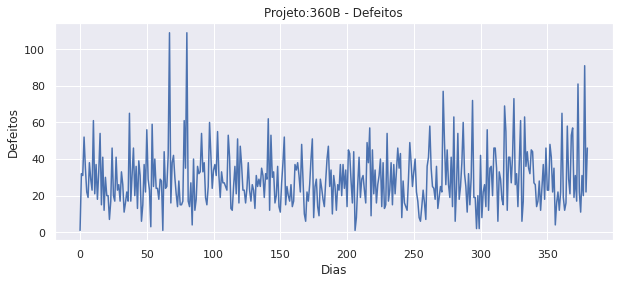

In [323]:
# Para visualizar os defeitos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 4))
plt.title('Projeto:'+p+' - Defeitos')
plt.xlabel("Dias")
plt.ylabel("Defeitos")
plt.plot(df['y'])
plt.show()

In [324]:
# Selecionando apenas a colunas de defeitos
df = df[['y']]

In [325]:
#Criação de uma variável para prever ‘X’ dias no futuro:
diasfuturos = tempo

In [326]:
#Crie uma nova coluna de destino deslocada em unidades / dias de ‘X’:
df['Prediction'] = df[['y']].shift(-diasfuturos)
print(df.head())
print(df.tail())

    y Prediction
0   1         17
1  32         33
2  31         26
3  52         11
4  35         16
      y Prediction
376  31        NaN
377  20        NaN
378  91        NaN
379  22        NaN
380  46        NaN


In [327]:
#Para criar um conjunto de dados de recursos (x) e converter em uma matriz numpy e remover as últimas ‘x’ linhas / dias:
import numpy as np
x = np.array(df.drop(["Prediction"], 1))[:-diasfuturos]
print(x)

[[1]
 [32]
 [31]
 [52]
 [35]
 [22]
 [19]
 [38]
 [29]
 [23]
 [61]
 [21]
 [37]
 [18]
 [33]
 [54]
 [15]
 [41]
 [12]
 [30]
 [20]
 [20]
 [7]
 [17]
 [46]
 [20]
 [17]
 [41]
 [23]
 [26]
 [17]
 [33]
 [26]
 [11]
 [16]
 [22]
 [17]
 [65]
 [17]
 [31]
 [46]
 [20]
 [36]
 [13]
 [39]
 [31]
 [6]
 [15]
 [37]
 [22]
 [56]
 [29]
 [23]
 [3]
 [59]
 [25]
 [40]
 [24]
 [24]
 [18]
 [29]
 [28]
 [1]
 [44]
 [24]
 [25]
 [42]
 [109]
 [16]
 [38]
 [42]
 [30]
 [21]
 [14]
 [28]
 [15]
 [15]
 [17]
 [61]
 [35]
 [109]
 [17]
 [14]
 [27]
 [4]
 [40]
 [12]
 [18]
 [36]
 [32]
 [33]
 [54]
 [33]
 [38]
 [19]
 [15]
 [25]
 [60]
 [42]
 [24]
 [34]
 [37]
 [31]
 [55]
 [31]
 [19]
 [33]
 [27]
 [27]
 [25]
 [23]
 [53]
 [41]
 [13]
 [12]
 [25]
 [36]
 [21]
 [51]
 [16]
 [47]
 [37]
 [23]
 [23]
 [16]
 [24]
 [38]
 [23]
 [17]
 [26]
 [23]
 [13]
 [31]
 [25]
 [29]
 [25]
 [35]
 [31]
 [19]
 [32]
 [29]
 [62]
 [12]
 [53]
 [30]
 [33]
 [16]
 [20]
 [36]
 [14]
 [11]
 [27]
 [38]
 [52]
 [15]
 [25]
 [20]
 [17]
 [26]
 [14]
 [17]
 [37]
 [34]
 [38]
 [31]
 [22]
 [48]
 [

In [328]:
#Para criar um conjunto de dados de destino (y) e convertê-lo em uma matriz numpy e obter todos os valores de destino, exceto os últimos ‘x’ linhas dias:
y = np.array(df["Prediction"])[:-diasfuturos]
print(y)

[17 33 26 11 16 22 17 65 17 31 46 20 36 13 39 31 6 15 37 22 56 29 23 3 59
 25 40 24 24 18 29 28 1 44 24 25 42 109 16 38 42 30 21 14 28 15 15 17 61
 35 109 17 14 27 4 40 12 18 36 32 33 54 33 38 19 15 25 60 42 24 34 37 31
 55 31 19 33 27 27 25 23 53 41 13 12 25 36 21 51 16 47 37 23 23 16 24 38
 23 17 26 23 13 31 25 29 25 35 31 19 32 29 62 12 53 30 33 16 20 36 14 11
 27 38 52 15 25 20 17 26 14 17 37 34 38 31 22 48 29 10 6 22 17 26 40 51 8
 25 29 14 9 29 24 18 14 28 40 47 25 34 10 31 25 12 26 23 37 20 37 24 34 14
 45 43 28 16 44 1 8 26 41 19 29 31 23 16 49 38 57 9 45 21 34 16 26 31 40
 14 38 13 15 54 17 23 38 15 37 21 33 46 35 43 8 28 16 14 12 29 49 38 25 33
 40 22 17 8 6 14 23 16 7 36 41 58 35 25 24 18 36 13 19 25 22 77 49 26 45
 26 19 41 14 63 6 24 54 18 25 38 60 32 25 11 32 15 30 72 19 19 2 20 2 42 8
 22 26 14 56 12 35 36 20 46 46 35 6 33 29 18 15 69 55 12 41 41 27 42 73 26
 32 14 37 61 6 17 63 36 44 35 32 45 44 27 26 14 17 28 12 25 37 18 46 23 23
 48 41 22 35 4 16 22 12 22 65 19 12 16 

In [329]:
#Dividindo os dados em 75% de treinamento e 25% de teste
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)

In [330]:
# Criando os modelos...
# Criação do modelo de regressor de árvore de decisão
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor().fit(xtrain, ytrain)

# criando o modelo de regressão linear
from sklearn.linear_model import LinearRegression
linear = LinearRegression().fit(xtrain, ytrain)

In [331]:
#Para obter os últimos ‘x’ linhas / dias do conjunto de dados do recurso
xfuturo = df.drop(["Prediction"], 1)[:-diasfuturos]
xfuturo = xfuturo.tail(diasfuturos)
xfuturo = np.array(xfuturo)
print(xfuturo)

[[41]
 [41]
 [27]
 [42]
 [73]
 [26]
 [32]
 [14]
 [37]
 [61]
 [6]
 [17]
 [63]
 [36]
 [44]
 [35]
 [32]
 [45]
 [44]
 [27]
 [26]
 [14]
 [17]
 [28]
 [12]
 [25]
 [37]
 [18]
 [46]
 [23]]


In [332]:
# Para ver a previsão da árvore modelo
treePrediction = tree.predict(xfuturo)
print("Previsão da árvore de decisão =",treePrediction)

Previsão da árvore de decisão = [30.         30.         21.2        31.8        35.         30.
 28.16666667 25.         35.5        46.         33.66666667 35.72727273
 29.         22.         44.33333333 26.85714286 28.16666667 39.
 44.33333333 21.2        30.         25.         35.72727273 42.25
 30.5        33.         35.5        23.83333333 30.25       35.18181818]


In [333]:
# Para ver a previsão de regressão linear do modelo
linearPrediction = linear.predict(xfuturo)
print("Previsão de regressão linear =",linearPrediction)

Previsão de regressão linear = [29.06097088 29.06097088 28.49336887 29.10151388 30.3583469  28.45282587
 28.69608388 27.96630987 28.89879888 29.87183089 27.64196586 28.08793887
 29.95291689 28.85825588 29.18259988 28.81771288 28.69608388 29.22314288
 29.18259988 28.49336887 28.45282587 27.96630987 28.08793887 28.53391187
 27.88522387 28.41228287 28.89879888 28.12848187 29.26368588 28.33119687]


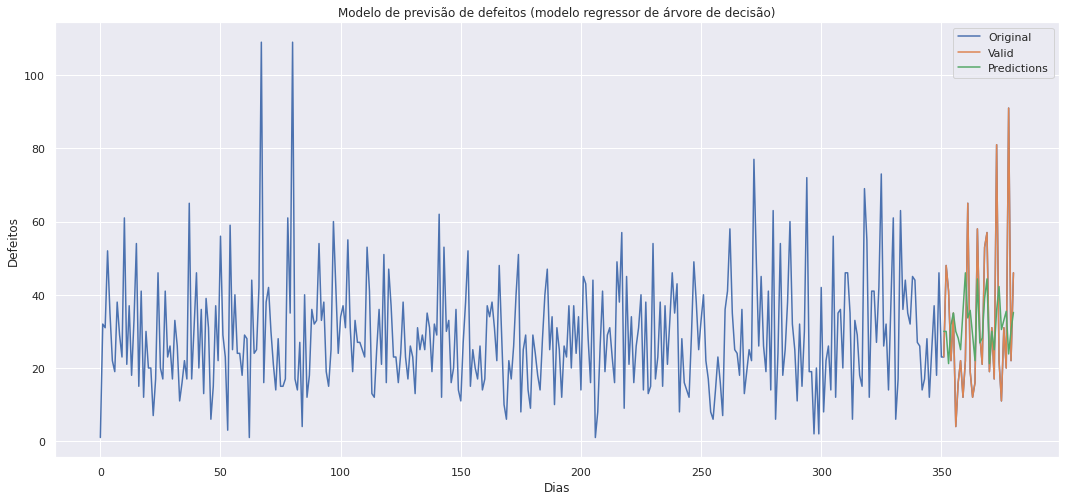

In [334]:
# Visualize as previsões da árvore de decisão
predictions = treePrediction
valid = df[x.shape[0]:]
valid["Predictions"] = predictions
plt.figure(figsize=(18, 8))
plt.title("Modelo de previsão de defeitos (modelo regressor de árvore de decisão)")
plt.xlabel("Dias")
plt.ylabel("Defeitos")
plt.plot(df["y"])
plt.plot(valid[["y", "Predictions"]])
plt.legend(["Original", "Valid", "Predictions"])
plt.show()

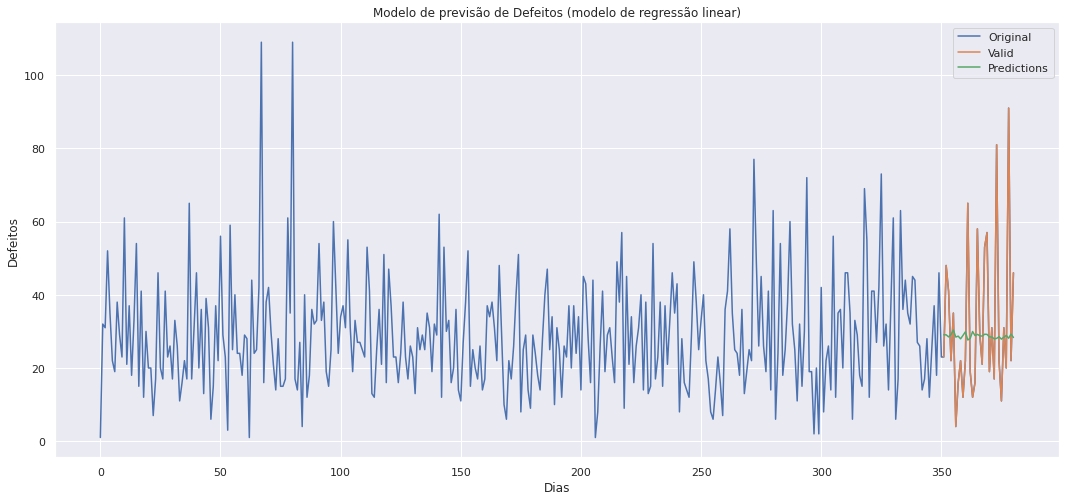

In [335]:
# Visualize as previsões do modelo linear
predictions = linearPrediction
valid = df[x.shape[0]:]
valid["Predictions"] = predictions
plt.figure(figsize=(18, 8))
plt.title("Modelo de previsão de Defeitos (modelo de regressão linear)")
plt.xlabel("Dias")
plt.ylabel("Defeitos")
plt.plot(df["y"])
plt.plot(valid[["y", "Predictions"]])
plt.legend(["Original", "Valid", "Predictions"])
plt.show()

#Previsão de defeitos com Machine Learning (Support Vector Machines(Regression))

In [336]:
# Carregando dados
df = carregar(p,t)

Projeto:  360B


In [337]:
# Removendo a coluna data
df.drop(['ds'],axis=1,inplace=True)

In [338]:
# Agora vamos criar uma variável para prever ‘n’ dias no futuro
predictionDays = 30
# Crie outra coluna deslocada 'n' unidades para cima
df['Prediction'] = df[['y']].shift(-predictionDays)
# Exibindo as 5 primeiras linhas
df.head()

,y,Prediction
0,1,17
1,32,33
2,31,26
3,52,11
4,35,16


In [339]:
# Últimas 5 linhas
df.tail()

,y,Prediction
376,31,NaN
377,20,NaN
378,91,NaN
379,22,NaN
380,46,NaN


In [340]:
# Crie o conjunto de dados independente
# Aqui, converteremos o quadro de dados em uma matriz numpy e removeremos a coluna de previsão
x = np.array(df.drop(['Prediction'],1))
# Remova as últimas 'n' linhas, onde 'n' é o predictionDays
x = x[:len(df)-predictionDays]
print(x)

[[1]
 [32]
 [31]
 [52]
 [35]
 [22]
 [19]
 [38]
 [29]
 [23]
 [61]
 [21]
 [37]
 [18]
 [33]
 [54]
 [15]
 [41]
 [12]
 [30]
 [20]
 [20]
 [7]
 [17]
 [46]
 [20]
 [17]
 [41]
 [23]
 [26]
 [17]
 [33]
 [26]
 [11]
 [16]
 [22]
 [17]
 [65]
 [17]
 [31]
 [46]
 [20]
 [36]
 [13]
 [39]
 [31]
 [6]
 [15]
 [37]
 [22]
 [56]
 [29]
 [23]
 [3]
 [59]
 [25]
 [40]
 [24]
 [24]
 [18]
 [29]
 [28]
 [1]
 [44]
 [24]
 [25]
 [42]
 [109]
 [16]
 [38]
 [42]
 [30]
 [21]
 [14]
 [28]
 [15]
 [15]
 [17]
 [61]
 [35]
 [109]
 [17]
 [14]
 [27]
 [4]
 [40]
 [12]
 [18]
 [36]
 [32]
 [33]
 [54]
 [33]
 [38]
 [19]
 [15]
 [25]
 [60]
 [42]
 [24]
 [34]
 [37]
 [31]
 [55]
 [31]
 [19]
 [33]
 [27]
 [27]
 [25]
 [23]
 [53]
 [41]
 [13]
 [12]
 [25]
 [36]
 [21]
 [51]
 [16]
 [47]
 [37]
 [23]
 [23]
 [16]
 [24]
 [38]
 [23]
 [17]
 [26]
 [23]
 [13]
 [31]
 [25]
 [29]
 [25]
 [35]
 [31]
 [19]
 [32]
 [29]
 [62]
 [12]
 [53]
 [30]
 [33]
 [16]
 [20]
 [36]
 [14]
 [11]
 [27]
 [38]
 [52]
 [15]
 [25]
 [20]
 [17]
 [26]
 [14]
 [17]
 [37]
 [34]
 [38]
 [31]
 [22]
 [48]
 [

In [341]:
# Crie o conjunto de dados dependente
# converter o quadro de dados em um array numpy
y = np.array(df['Prediction'])
# Obtenha todos os valores, exceto as últimas 'n' linhas
y = y[:-predictionDays]
print(y)

[17 33 26 11 16 22 17 65 17 31 46 20 36 13 39 31 6 15 37 22 56 29 23 3 59
 25 40 24 24 18 29 28 1 44 24 25 42 109 16 38 42 30 21 14 28 15 15 17 61
 35 109 17 14 27 4 40 12 18 36 32 33 54 33 38 19 15 25 60 42 24 34 37 31
 55 31 19 33 27 27 25 23 53 41 13 12 25 36 21 51 16 47 37 23 23 16 24 38
 23 17 26 23 13 31 25 29 25 35 31 19 32 29 62 12 53 30 33 16 20 36 14 11
 27 38 52 15 25 20 17 26 14 17 37 34 38 31 22 48 29 10 6 22 17 26 40 51 8
 25 29 14 9 29 24 18 14 28 40 47 25 34 10 31 25 12 26 23 37 20 37 24 34 14
 45 43 28 16 44 1 8 26 41 19 29 31 23 16 49 38 57 9 45 21 34 16 26 31 40
 14 38 13 15 54 17 23 38 15 37 21 33 46 35 43 8 28 16 14 12 29 49 38 25 33
 40 22 17 8 6 14 23 16 7 36 41 58 35 25 24 18 36 13 19 25 22 77 49 26 45
 26 19 41 14 63 6 24 54 18 25 38 60 32 25 11 32 15 30 72 19 19 2 20 2 42 8
 22 26 14 56 12 35 36 20 46 46 35 6 33 29 18 15 69 55 12 41 41 27 42 73 26
 32 14 37 61 6 17 63 36 44 35 32 45 44 27 26 14 17 28 12 25 37 18 46 23 23
 48 41 22 35 4 16 22 12 22 65 19 12 16 

In [342]:
# Divida os dados em 80% de treinamento e 20% de teste
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.2)
# definir a matriz predictionDays igual às últimas 30 linhas do conjunto de dados original
predictionDays_array = np.array(df.drop(['Prediction'],1))[-predictionDays:]
print(predictionDays_array)

[[23]
 [48]
 [41]
 [22]
 [35]
 [4]
 [16]
 [22]
 [12]
 [22]
 [65]
 [19]
 [12]
 [16]
 [58]
 [29]
 [21]
 [53]
 [57]
 [19]
 [31]
 [17]
 [81]
 [22]
 [11]
 [31]
 [20]
 [91]
 [22]
 [46]]


In [343]:
# Agora vamos criar um modelo de aprendizado de máquina
from sklearn.svm import SVR
# Criar e treinar a máquina de vetores de suporte (regressão) usando a função de base radial
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.00001)
svr_rbf.fit(xtrain, ytrain)

SVR(C=1000.0, gamma=1e-05)

In [344]:
# Teste o modelo
svr_rbf_confidence = svr_rbf.score(xtest,ytest)
print('SVR_RBF accuracy :',svr_rbf_confidence)

SVR_RBF accuracy : -0.05579987151181087


In [345]:
# imprime os valores previstos
svm_prediction = svr_rbf.predict(xtest)
print(svm_prediction)
print()
print(ytest)

[25.89521385 25.41529449 25.81638567 25.41529449 25.77764068 25.07122543
 26.18488885 26.31543018 26.22798393 25.85557757 25.07122543 26.09996935
 24.42557835 25.48405783 25.34841801 25.77764068 25.34841801 25.73934507
 26.14221636 26.27149869 25.62717874 25.22038744 25.15926239 26.31543018
 26.49526291 25.85557757 24.74123739 25.12942839 24.85815883 25.07122543
 25.51914197 25.93529193 24.67714819 25.22038744 25.73934507 25.55469163
 25.22038744 25.77764068 24.48139815 25.73934507 26.31543018 26.016763
 26.14221636 25.44944131 25.70150129 26.22798393 26.18488885 25.31569225
 24.6176327  26.09996935 26.82529526 25.77764068 25.62717874 26.44969486
 26.22798393 24.698004   25.48405783 25.81638567 25.66411173 25.73934507
 26.22798393 25.04285953 26.18488885 25.55469163 24.98760614 25.77764068
 25.93529193 26.31543018 25.31569225 25.3816194  25.31569225]

[37 48 36 16 22 13 41 23 36 29 27 16 22 35 13 34 27 17 25 53 31 32 23 45
 18 14 4 57 31 59 69 33 17 48 14 21 23 55 35 26 30 16 15 9 31 2

In [346]:
# Imprima as previsões do modelo para os próximos 30 dias
svm_prediction = svr_rbf.predict(predictionDays_array)
print(svm_prediction)
print()
# Imprimir o preço real do bitcoin nos últimos 30 dias
print(df.tail(predictionDays))

[25.85557757 25.01498597 25.22038744 25.89521385 25.41529449 26.68151639
 26.14221636 25.89521385 26.31543018 25.89521385 24.6176327  26.016763
 26.31543018 26.14221636 24.7636134  25.62717874 25.93529193 24.88305061
 24.78649448 26.016763   25.55469163 26.09996935 24.37796467 25.89521385
 26.3597754  25.55469163 25.9758092  24.2947365  25.89521385 25.07122543]

      y Prediction
351  23        NaN
352  48        NaN
353  41        NaN
354  22        NaN
355  35        NaN
356   4        NaN
357  16        NaN
358  22        NaN
359  12        NaN
360  22        NaN
361  65        NaN
362  19        NaN
363  12        NaN
364  16        NaN
365  58        NaN
366  29        NaN
367  21        NaN
368  53        NaN
369  57        NaN
370  19        NaN
371  31        NaN
372  17        NaN
373  81        NaN
374  22        NaN
375  11        NaN
376  31        NaN
377  20        NaN
378  91        NaN
379  22        NaN
380  46        NaN


# COMPARAÇÃO

In [287]:
#Previsão de defeitos com Prophet do Facebook
fig = px.line(previsao_def, x='Data', y='Qtde defeitos', title='Projeto: '+p)
fig.show()

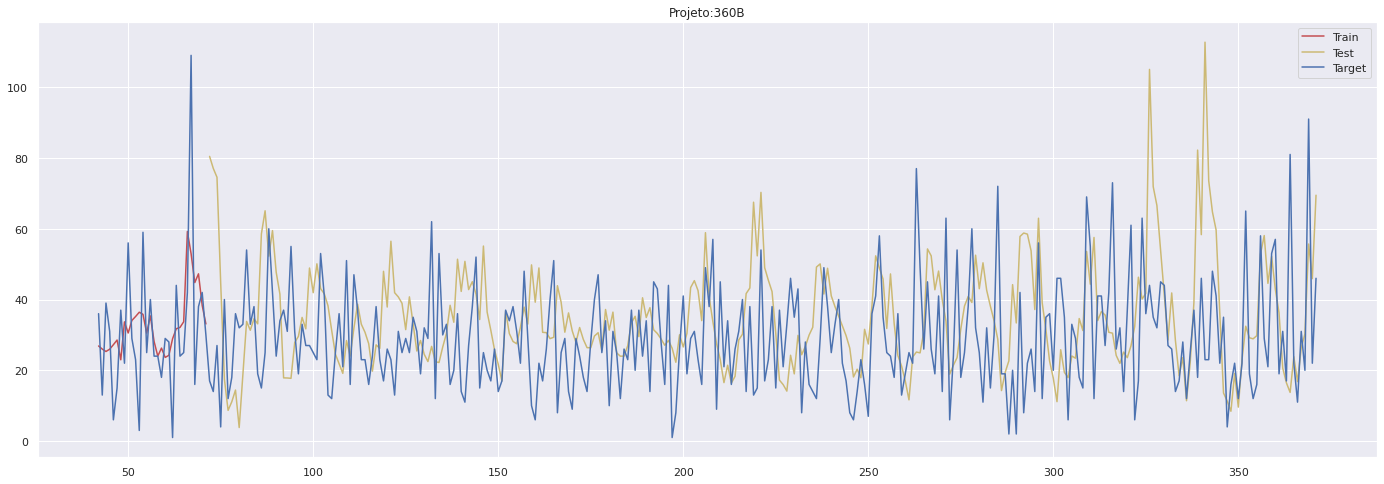

In [292]:
# Previsão de defeitos com rede LSTM
plt.figure(figsize = (24,8))

plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')

plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')
plt.title('Projeto:'+p)
plt.legend(loc='best')
plt.show()

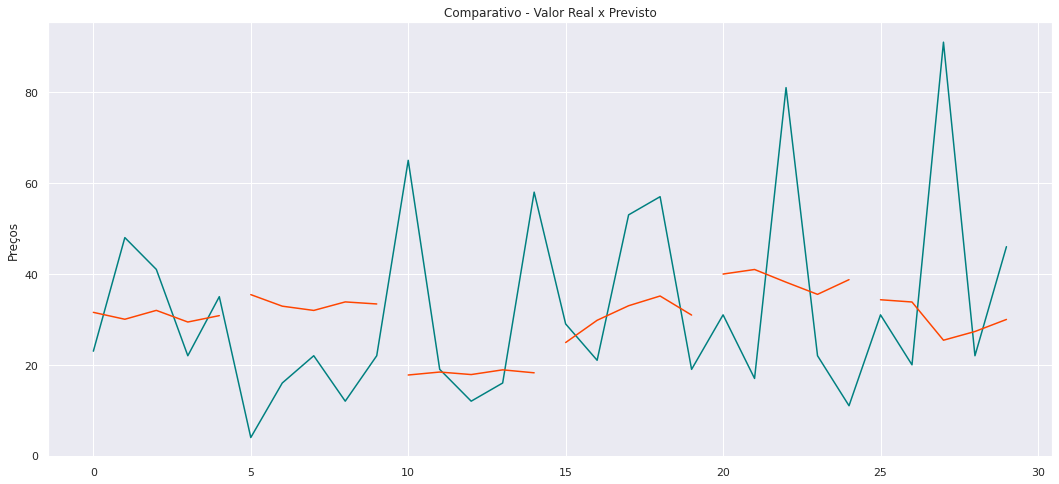

In [313]:
plotar_comparativo(teste['y'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo - Valor Real x Previsto')

In [320]:
# Previsão de defeitos AutoTS
forecast = pd.DataFrame(forecast)
forecast['Data'] = forecast.index
fig = px.line(forecast, x='Data', y='y', title='Projeto: '+p)
fig.show()